## Rohlik orders forecasts
This notebook contains a time series forecasting task with Rohlik dataset EDA and data preprocessing and as an engine using LSTM model with Tensorflow 2 backend. 

<br><b>Approach:</b>
<br>As Rohlík orders dataset contains data from multiple warehouses, thus it contains multiple timelines, the approach is to process and predict each warehouse as a separate timeline. The preprocessing, fiting and evaluation steps are the same for each warehouse.

<br>This approach yields very good MAPE value, which is calculated as a mean of all warehouse timeline results.

In [885]:
! pip -q install pandas matplotlib numpy seaborn
! pip install -q scikit-learn
! pip install -q joblib
! pip install -q tensorflow

In [886]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization, Input
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import joblib
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy import interpolate


TIME_STEPS = 63
EPOCHS = 100
BATCH_SIZE = 16
WAREHOUSE = "Prague_1" # For testing purposes

# Temporal features
#LAG_DAYS = [7, 28, 56, 84, 168, 364]
#ROLLING_WINDOW = [28, 168, 364]
LAG_DAYS = [63, 119, 168, 364]
ROLLING_WINDOW = [63, 168, 364]

pd.set_option('display.max_columns', None)

train_df_raw = pd.read_csv("data/train.csv")
train_calendar_df_raw = pd.read_csv("data/train_calendar.csv")
test_df_raw = pd.read_csv("data/test.csv")
test_calendar_df_raw = pd.read_csv("data/test_calendar.csv")

train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])
train_calendar_df_raw['date'] = pd.to_datetime(train_calendar_df_raw['date'])
test_df_raw['date'] = pd.to_datetime(test_df_raw['date'])
test_calendar_df_raw['date'] = pd.to_datetime(test_calendar_df_raw['date'])

### Optional Dataset Validation

Evaluate the data correctness. Check both .csvs if their values in the same columns match and then merge them into one dataset.

In [887]:
def merge_csv(train_df, train_calendar_df):
    # Identify common columns
    common_columns = set(train_df.columns).intersection(set(train_calendar_df.columns))
    print(common_columns)

    # Merg the two datasets on warehouse and date
    merged_df_to_test = pd.merge(train_df, train_calendar_df, on=['date', 'warehouse'], suffixes=('_train', '_calendar'))
    
        # Compare values in common columns
    differences = {}
    for column in common_columns:
        if column not in ['date', 'warehouse']:  # Exclude join keys from comparison
            train_col = f"{column}_train"
            calendar_col = f"{column}_calendar"
            
            # Check if there are any differences, excluding rows where both values are NaN
            diff = merged_df_to_test[(merged_df_to_test[train_col] != merged_df_to_test[calendar_col]) & 
                            (~merged_df_to_test[train_col].isna() | ~merged_df_to_test[calendar_col].isna())]
            if not diff.empty:
                differences[column] = diff[['date', 'warehouse', train_col, calendar_col]]
            else:
                print(f"No differences found in column: {column}")

    # Display only the rows where values were different
    for col, diff in differences.items():
        print(f"\nNot merged. Differences found in column: {col}")
        print(diff)
        return

    if not differences:
        print("\nSuccess. All values match across the datasets, datasets merged.")
        return pd.merge(train_df, train_calendar_df, on=list(common_columns))


In [888]:
# Merg the two datasets on 'date' and 'warehouse' to facilitate comparison
train_df_merged = merge_csv(train_df_raw, train_calendar_df_raw)
test_df_merged = merge_csv(test_df_raw, test_calendar_df_raw) 

{'winter_school_holidays', 'mov_change', 'shutdown', 'blackout', 'date', 'shops_closed', 'school_holidays', 'holiday', 'mini_shutdown', 'precipitation', 'snow', 'holiday_name', 'frankfurt_shutdown', 'warehouse'}
No differences found in column: winter_school_holidays
No differences found in column: mov_change
No differences found in column: shutdown
No differences found in column: blackout
No differences found in column: shops_closed
No differences found in column: school_holidays
No differences found in column: holiday
No differences found in column: mini_shutdown
No differences found in column: precipitation
No differences found in column: snow
No differences found in column: holiday_name
No differences found in column: frankfurt_shutdown

Success. All values match across the datasets, datasets merged.
{'winter_school_holidays', 'date', 'shops_closed', 'school_holidays', 'holiday', 'holiday_name', 'warehouse'}
No differences found in column: winter_school_holidays
No differences found

In [889]:
train_df = train_df_merged.sort_values(by=['date', 'warehouse'])
test_df = test_df_merged.sort_values(by=['date', 'warehouse'])

### Drop unnecesary data
There are some data in the training set that will not be availiable in the testing / inference data inputs.

In [890]:
# get features that are not available in the test dataset
unavailable_features = list(set(train_df.columns).difference(set(test_df.columns)))    
unavailable_features.remove('orders')

print(f"Common features: {unavailable_features}")

Common features: ['mov_change', 'shutdown', 'blackout', 'user_activity_2', 'warehouse_limited', 'mini_shutdown', 'precipitation', 'user_activity_1', 'snow', 'frankfurt_shutdown']


In [891]:
train_df = train_df.drop(columns=unavailable_features)

In [892]:
# list redundant columns that have unchanging values
# There are unchanging values in single particular warehouse timelines, but we leave it as is.

unchanging_columns = []
for column in train_df.columns:
    if train_df[column].nunique() == 1:
        unchanging_columns.append(column)
print(unchanging_columns)

train_df = train_df.drop(columns=unchanging_columns)

[]


In [893]:
# Some features with little movement, not sure what value do these features bring to the model, as they are unbalanced among timelines, but we leave them for now.

for warehouse in train_df['warehouse'].unique():
    print(f"\nWarehouse: {warehouse}")
    for feature in train_df.columns:
        values = train_df[feature].nunique()
        if values == 2:
            print(f"Feature {feature} has {values} unique values")
            # list values only for the current warehouse:
            print(sum(train_df[train_df['warehouse']==warehouse][feature]==1))


Warehouse: Brno_1
Feature holiday has 2 unique values
45
Feature shops_closed has 2 unique values
20
Feature winter_school_holidays has 2 unique values
28
Feature school_holidays has 2 unique values
0

Warehouse: Budapest_1
Feature holiday has 2 unique values
9
Feature shops_closed has 2 unique values
0
Feature winter_school_holidays has 2 unique values
6
Feature school_holidays has 2 unique values
0

Warehouse: Prague_1
Feature holiday has 2 unique values
45
Feature shops_closed has 2 unique values
20
Feature winter_school_holidays has 2 unique values
84
Feature school_holidays has 2 unique values
0

Warehouse: Prague_2
Feature holiday has 2 unique values
45
Feature shops_closed has 2 unique values
20
Feature winter_school_holidays has 2 unique values
28
Feature school_holidays has 2 unique values
0

Warehouse: Prague_3
Feature holiday has 2 unique values
45
Feature shops_closed has 2 unique values
20
Feature winter_school_holidays has 2 unique values
28
Feature school_holidays has 2

In [894]:
print(train_df.columns)
print(f"train data: {train_df.shape}")
print(f"test data: {test_df.shape}")

Index(['warehouse', 'date', 'orders', 'holiday_name', 'holiday',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'id'],
      dtype='object')
train data: (7340, 9)
test data: (397, 8)


In [895]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

warehouse                    0
date                         0
orders                       0
holiday_name              7122
holiday                      0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
id                           0
dtype: int64
warehouse                   0
date                        0
holiday_name              380
holiday                     0
shops_closed                0
winter_school_holidays      0
school_holidays             0
id                          0
dtype: int64


In [896]:
test_df.head()

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
61,Brno_1,2024-03-16,NaN,0,0,0,0,Brno_1_2024-03-16
340,Budapest_1,2024-03-16,NaN,0,0,0,0,Budapest_1_2024-03-16
292,Frankfurt_1,2024-03-16,NaN,0,0,0,0,Frankfurt_1_2024-03-16
244,Munich_1,2024-03-16,NaN,0,0,0,0,Munich_1_2024-03-16
0,Prague_1,2024-03-16,NaN,0,0,0,0,Prague_1_2024-03-16


In [897]:
# What is the gap between the date of the last training data and the first test data?
train_max_date = train_df['date'].max()
test_min_date = test_df['date'].min()
print(f"Train max date: {train_max_date}")
print(f"Test min date: {test_min_date}")
print(f"Gap: {test_min_date - train_max_date}")

Train max date: 2024-03-15 00:00:00
Test min date: 2024-03-16 00:00:00
Gap: 1 days 00:00:00


In [898]:
# merge the two datasets to facilitate data preprocessing and lag features generation   
train_df = pd.concat([train_df, test_df], axis=0)

In [899]:
train_df = train_df.sort_values(by=['date', 'warehouse'])

In [900]:
# only get data of one warehouse for the dataset
if WAREHOUSE != "None":
    train_df = train_df[train_df['warehouse'] == WAREHOUSE]

In [901]:
from math import pi

def process_date(df):
    df.index = df.pop('date')
    
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    df['days_since_start'] = (df.index - df.index.min()).days
    
    df['year_sin'] = df['year'] * np.sin(2 * pi * df['year'])
    df['year_cos'] = df['year'] * np.cos(2 * pi * df['year'])
    df['month_sin'] = df['month'] * np.sin(2 * pi * df['month'])
    df['month_cos'] = df['month'] * np.cos(2 * pi * df['month'])
    df['day_sin'] = df['day'] * np.sin(2 * pi * df['day'])
    df['day_cos'] = df['day'] * np.cos(2 * pi * df['day'])
    
    time_features = ['day', 'days_since_start', 'month', 'day_of_year', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_cos', 'day_sin']
    categorical_features = ['day_of_week', 'quarter', 'year'] 
    binary_features = ['is_weekend']
    return df, time_features, categorical_features, binary_features

### Features categories:
- time_features
- numerical_features
- categorical_features

In [902]:
train_df, time_features, categorical_features, binary_features=process_date(train_df)
binary_features = binary_features + ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']

In [903]:
train_df = train_df.drop(columns=['holiday_name']) 

### Plot

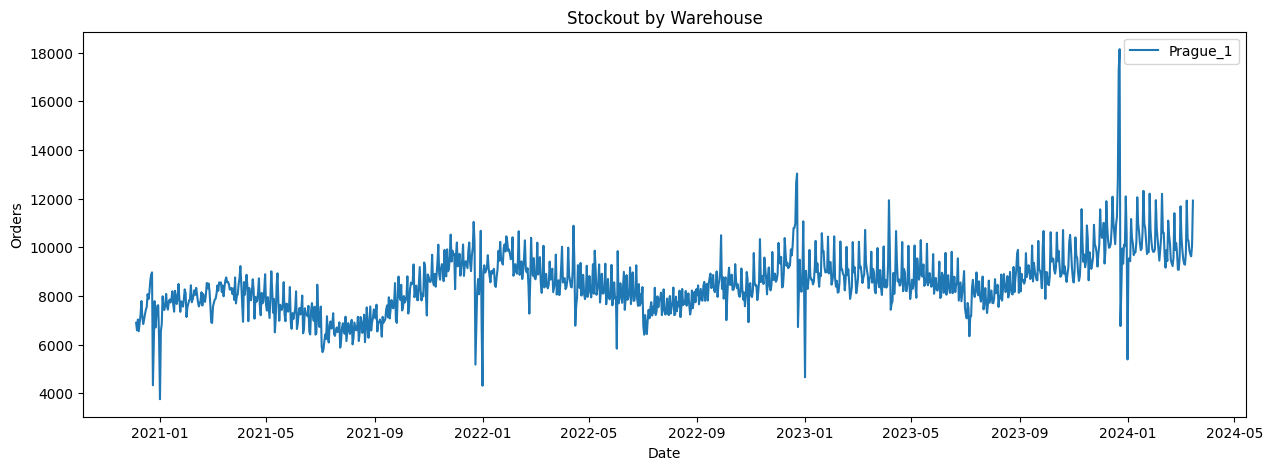

In [904]:
# Visualise the data
plt.figure(figsize=(15, 5))
for warehouse in train_df['warehouse'].unique():
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    plt.plot(warehouse_df.index, warehouse_df['orders'], label=warehouse)
plt.title("Stockout by Warehouse")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.legend()
plt.show()

<Axes: title={'center': 'Distribution'}, xlabel='Orders', ylabel='Frequency'>

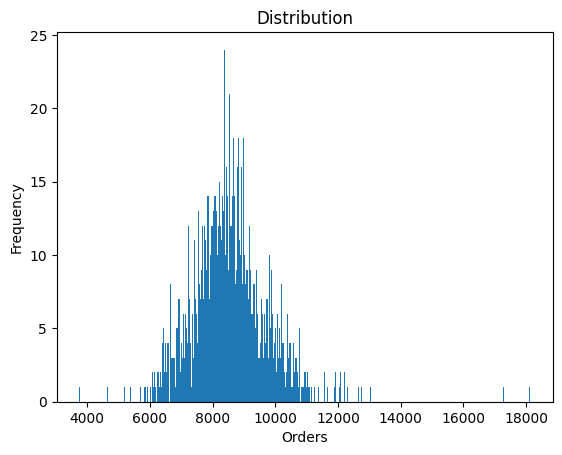

In [905]:
train_df['orders'].plot(kind='hist', bins=500, title='Distribution', xlabel='Orders')

<Axes: xlabel='date'>

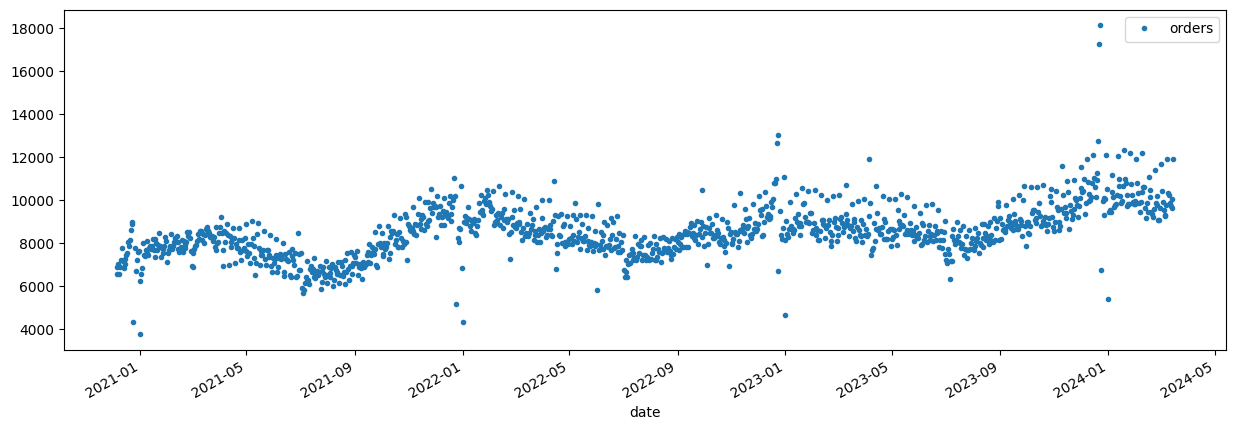

In [906]:
train_df.query('orders > 500').plot(y='orders', figsize=(15, 5), style='.')

In [907]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def z_score_outlier_detection(data, window=14, threshold=3):
    data = data.sort_index()
    rolling_mean = data.rolling(window=window, center=True, min_periods=1).mean()
    rolling_std = data.rolling(window=window, center=True, min_periods=1).std()
    z_scores = (data - rolling_mean) / rolling_std
    outliers = np.abs(z_scores) > threshold
    lower_bound = rolling_mean - (threshold * rolling_std)
    upper_bound = rolling_mean + (threshold * rolling_std)
    return outliers, lower_bound, upper_bound

def fix_outliers(data, outliers, window=14):
    fixed_data = data.copy()
    fixed_data[outliers] = np.nan
    fixed_data = fixed_data.interpolate()
    return fixed_data

def plot_outlier_comparison(train_df, window=28, z_threshold=3):
    warehouses = train_df['warehouse'].unique()
    n_warehouses = len(warehouses)
    
    n_cols = 1
    n_rows = n_warehouses
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10*n_rows))
    axes = axes.flatten() if n_warehouses > 1 else [axes]
    
    all_z_outliers = pd.Series(dtype=bool)
    
    for idx, warehouse in enumerate(warehouses):
        warehouse_data = train_df[train_df['warehouse'] == warehouse]['orders']
        
        z_outliers, z_lower, z_upper = z_score_outlier_detection(warehouse_data, window, z_threshold)
        fixed_warehouse_data = fix_outliers(warehouse_data, z_outliers, window=window)
        
        # Update the original DataFrame with fixed values
        train_df.loc[train_df['warehouse'] == warehouse, 'orders'] = fixed_warehouse_data
        
        all_z_outliers = pd.concat([all_z_outliers, z_outliers])
        
        # Plot the original data and outliers
        ax = axes[idx]
        ax.plot(warehouse_data.index, warehouse_data, label='Orders', alpha=0.7)
        
        # Plot Z-Score bounds and outliers
        ax.fill_between(warehouse_data.index, z_lower, z_upper, color='green', alpha=0.1, label='Z-Score Bounds')
        ax.scatter(warehouse_data.index[z_outliers], warehouse_data[z_outliers], color='green', label='Z-Score Outliers', marker='s')
        
        # Plot fixed outliers
        ax.scatter(warehouse_data.index[z_outliers], fixed_warehouse_data[z_outliers], color='orange', label='Fixed Outliers', marker='x')

        ax.set_title(f'{warehouse} - Outlier Comparison')
        ax.set_xlabel('Date')
        ax.set_ylabel('Orders')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary of outliers for each warehouse
    for warehouse in warehouses:
        warehouse_data = train_df[train_df['warehouse'] == warehouse]['orders']
        z_outliers, _, _ = z_score_outlier_detection(warehouse_data, window, z_threshold)
        
        print(f"\n{warehouse}:")
        print(f"Z-Score Outliers: {sum(z_outliers)}")
    
    return train_df




In [908]:
#train_df = plot_outlier_comparison(train_df, window=180, z_threshold=2.8)

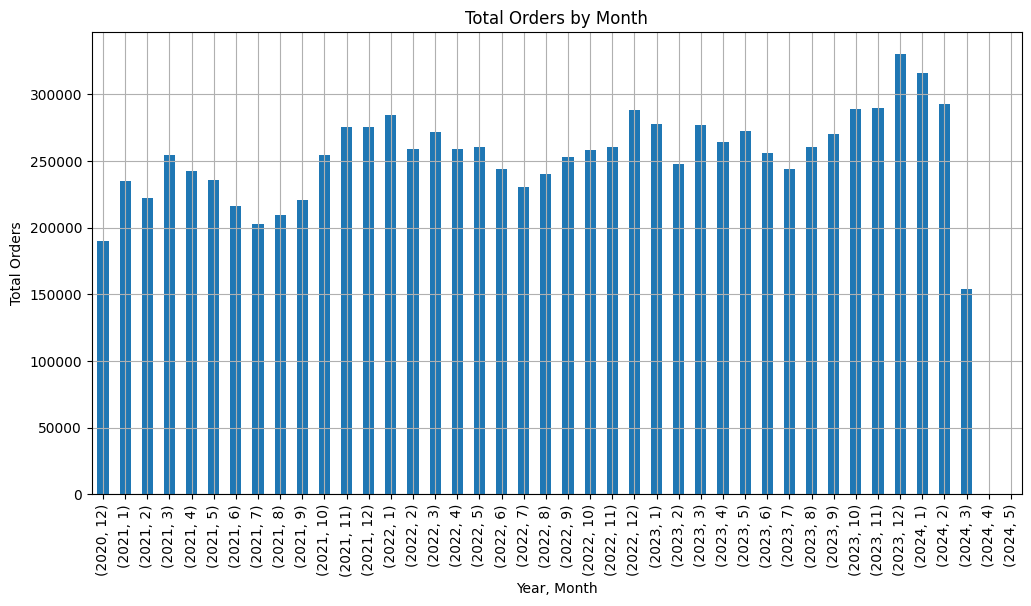

In [909]:

# plot the orders
df_by_month = train_df.groupby(['year', 'month'])['orders'].sum()
df_by_month.plot(kind='bar', figsize=(12, 6))

plt.title('Total Orders by Month')
plt.ylabel('Total Orders')
plt.xlabel('Year, Month')
plt.xticks(np.arange(len(df_by_month)), df_by_month.index, rotation=90)
plt.grid(True)
plt.show()


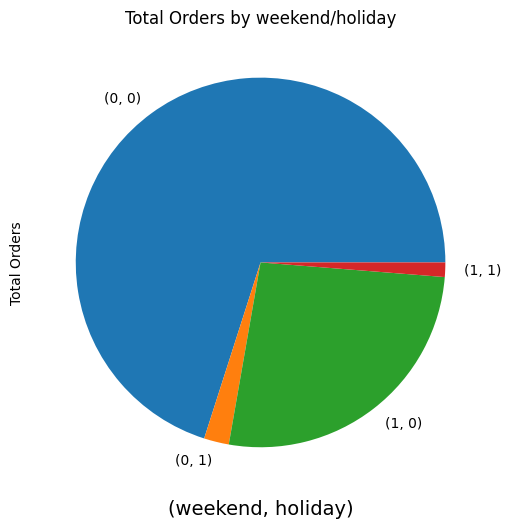

In [910]:
# plot the orders
df_by_month = train_df.groupby(['is_weekend', 'holiday'])['orders'].sum()
df_by_month.plot(kind='pie', figsize=(12, 6))

plt.title('Total Orders by weekend/holiday')
plt.ylabel('Total Orders')
plt.xlabel('(weekend, holiday)', fontdict={'fontsize': 14})
plt.show()

#### Compare feature Colerations

In [911]:
train_df_corr = train_df.drop(columns=['warehouse', "id"]).corr()

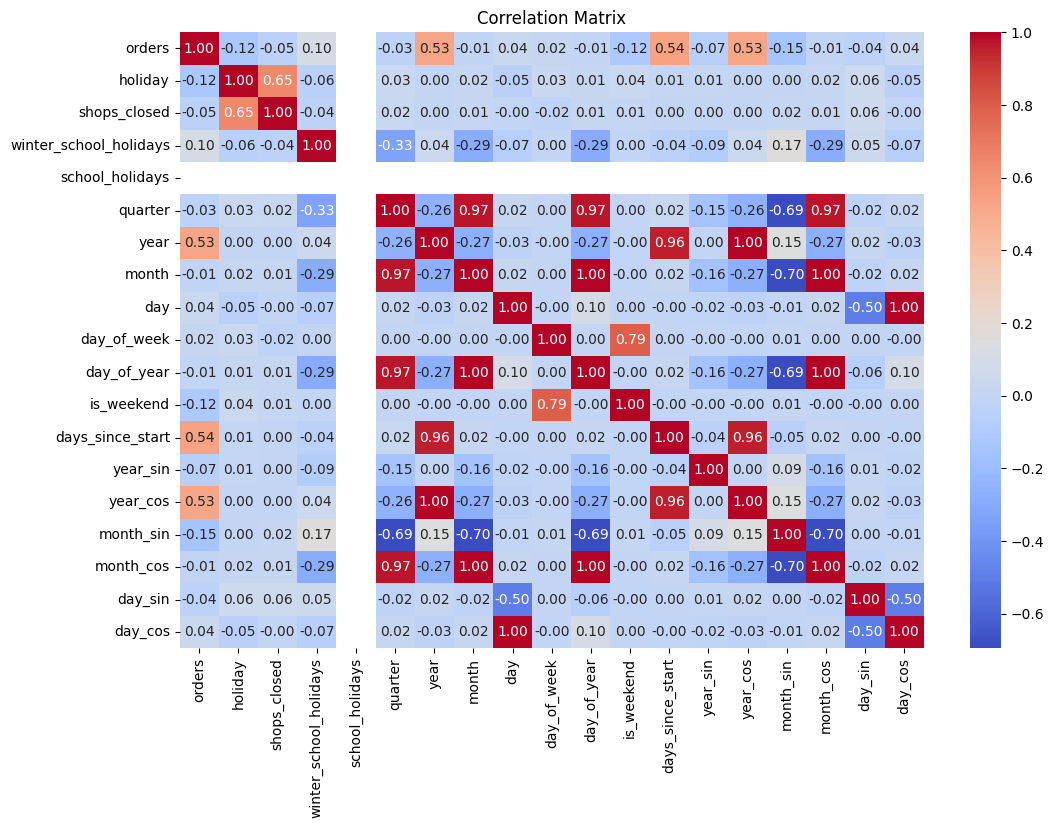

orders                    1.000000
days_since_start          0.537430
year_cos                  0.525746
year                      0.525746
winter_school_holidays    0.103458
day                       0.037290
day_cos                   0.037290
day_of_week               0.019032
day_of_year              -0.006400
month                    -0.011035
month_cos                -0.011035
quarter                  -0.033198
day_sin                  -0.037820
shops_closed             -0.045710
year_sin                 -0.065501
is_weekend               -0.116263
holiday                  -0.120545
month_sin                -0.149530
school_holidays                NaN
Name: orders, dtype: float64


In [912]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Print the correlation with 'orders'
print(train_df_corr['orders'].sort_values(ascending=False))

### Temporal features

In [913]:
def create_lag_features(df, col, lag_days):
    df = df.copy() 
    lag_features = []
    for lag in lag_days:
        feature_name = f'{col}_lag_{lag}'
        df[feature_name] = df.groupby('warehouse')[col].shift(lag)
        lag_features.append(feature_name)
    return df, lag_features

def create_rolling_features(df, col, windows):
    df = df.copy()
    window_features = []
    for window in windows:
        mean_feature = f'{col}_rolling_mean_{window}'
        std_feature = f'{col}_rolling_std_{window}'
        
        df[mean_feature] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
        df[std_feature] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).std())
        
        window_features.extend([mean_feature, std_feature])
    return df, window_features

In [914]:
# Create lag and rolling features for each warehouse at a time
warehouses = train_df['warehouse'].unique()
all_warehouses_data = []

for warehouse in warehouses:
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    warehouse_df, lag_features = create_lag_features(warehouse_df, 'orders', LAG_DAYS)
    warehouse_df, window_features = create_rolling_features(warehouse_df, 'orders', ROLLING_WINDOW)
    all_warehouses_data.append(warehouse_df)

# Concatenate all warehouse data back together
train_df = pd.concat(all_warehouses_data)

# Im putting my features into categories for better manipulation
numerical_features = ['orders']
numerical_features += lag_features + window_features
categorical_features = categorical_features

print(numerical_features)

train_df.head()

['orders', 'orders_lag_63', 'orders_lag_119', 'orders_lag_168', 'orders_lag_364', 'orders_rolling_mean_63', 'orders_rolling_std_63', 'orders_rolling_mean_168', 'orders_rolling_std_168', 'orders_rolling_mean_364', 'orders_rolling_std_364']


,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,orders_lag_63,orders_lag_119,orders_lag_168,orders_lag_364,orders_rolling_mean_63,orders_rolling_std_63,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,Prague_1,6895.0,0,0,0,0,Prague_1_2020-12-05,4,2020,12,5,5,340,1,0,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,NaN,NaN,NaN,NaN,6895.000000,NaN,6895.000000,NaN,6895.000000,NaN
2020-12-06,Prague_1,6584.0,0,0,0,0,Prague_1_2020-12-06,4,2020,12,6,6,341,1,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-8.817457e-15,6.0,NaN,NaN,NaN,NaN,6739.500000,219.910209,6739.500000,219.910209,6739.500000,219.910209
2020-12-07,Prague_1,7030.0,0,0,0,0,Prague_1_2020-12-07,4,2020,12,7,0,342,0,2,-1.630940e-09,2020.0,-3.526983e-14,12.0,-1.200154e-14,7.0,NaN,NaN,NaN,NaN,6836.333333,228.714524,6836.333333,228.714524,6836.333333,228.714524
2020-12-08,Prague_1,6550.0,0,0,0,0,Prague_1_2020-12-08,4,2020,12,8,1,343,0,3,-1.630940e-09,2020.0,-3.526983e-14,12.0,-1.567548e-14,8.0,NaN,NaN,NaN,NaN,6764.750000,235.308840,6764.750000,235.308840,6764.750000,235.308840
2020-12-09,Prague_1,6910.0,0,0,0,0,Prague_1_2020-12-09,4,2020,12,9,2,344,0,4,-1.630940e-09,2020.0,-3.526983e-14,12.0,-1.983928e-14,9.0,NaN,NaN,NaN,NaN,6793.800000,213.885951,6793.800000,213.885951,6793.800000,213.885951


In [915]:
# Process NAN values that appeared in the new features due to the lag and rolling window
#train_df[lag_features + window_features] = train_df[lag_features + window_features].fillna(method='ffill').fillna(method='bfill')
train_df[lag_features + window_features] = train_df[lag_features + window_features].fillna(0)

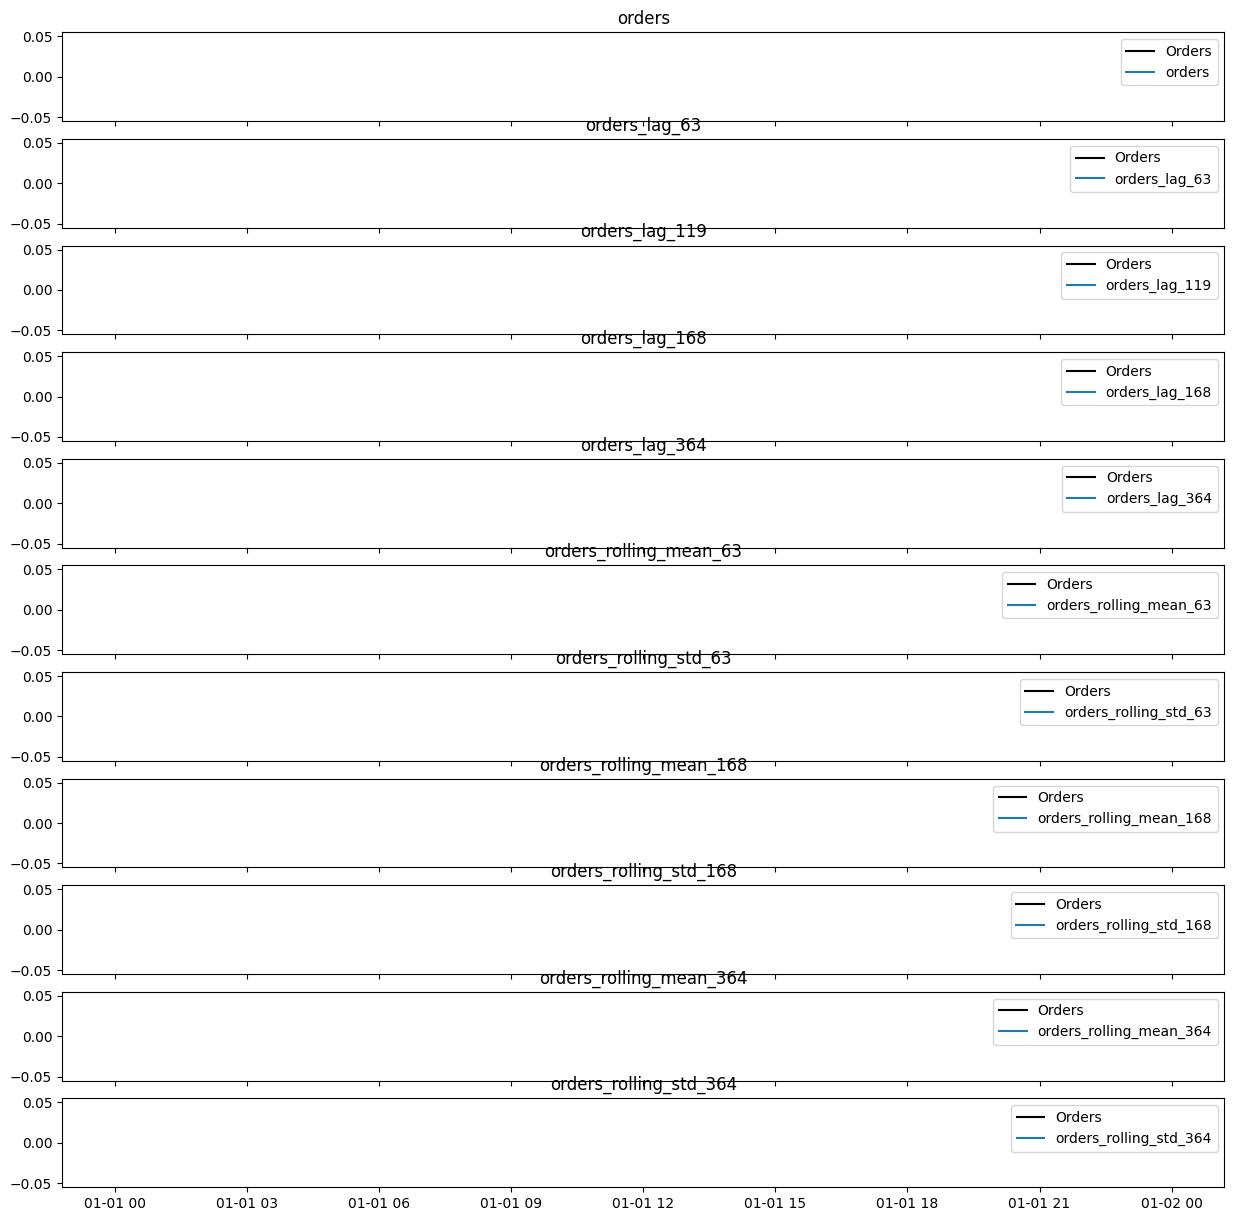

In [916]:
#orders and features above each other
fig, ax = plt.subplots(len(numerical_features), 1, figsize=(15, 15), sharex=True)
for i, feature in enumerate(numerical_features):
    ax[i].plot(train_df[train_df.warehouse == "Frankfurt_1"].index, train_df[train_df.warehouse == 'Frankfurt_1'].orders, label='Orders', color='black')
    ax[i].plot(train_df[train_df.warehouse == 'Frankfurt_1'].index, train_df[train_df.warehouse == 'Frankfurt_1'][feature], label=feature)
    ax[i].set_title(feature)
    ax[i].legend()
plt.show()


In [917]:
# divide dataset back into train and test datasets, for test set to export with new features and train to train on.
test_date_range = (test_df_merged.date.min(), test_df_merged.date.max())
train_date_range = (train_df_merged.date.min(), train_df_merged.date.max())

test_df = train_df.loc[(train_df.index >= test_date_range[0]) & (train_df.index <= test_date_range[1])]
test_df = test_df.drop(columns=['orders'])
train_df = train_df.loc[(train_df.index >= train_date_range[0]) & (train_df.index <= train_date_range[1])]

In [918]:
train_df.tail()

,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,orders_lag_63,orders_lag_119,orders_lag_168,orders_lag_364,orders_rolling_mean_63,orders_rolling_std_63,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-11,Prague_1,9866.0,0,0,0,0,Prague_1_2024-03-11,1,2024,3,11,0,71,0,1192,3.208798e-11,2024.0,-2.204364e-15,3.0,-1.077962e-13,11.0,9678.0,9406.0,9025.0,9068.0,10241.206349,821.806726,10019.238095,1307.358475,9238.887363,1261.408750
2024-03-12,Prague_1,9710.0,0,0,0,0,Prague_1_2024-03-12,1,2024,3,12,1,72,0,1193,3.208798e-11,2024.0,-2.204364e-15,3.0,-3.526983e-14,12.0,9766.0,9703.0,8844.0,8846.0,10240.317460,822.359113,10024.392857,1304.400824,9241.260989,1261.480310
2024-03-13,Prague_1,9628.0,0,0,0,0,Prague_1_2024-03-13,1,2024,3,13,2,73,0,1194,3.208798e-11,2024.0,-2.204364e-15,3.0,5.097749e-14,13.0,9800.0,9180.0,8316.0,8316.0,10237.587302,824.128115,10032.202381,1298.023249,9244.865385,1260.703436
2024-03-14,Prague_1,10056.0,0,0,0,0,Prague_1_2024-03-14,1,2024,3,14,3,74,0,1195,3.208798e-11,2024.0,-2.204364e-15,3.0,-4.800615e-14,14.0,10218.0,9404.0,10016.0,8696.0,10235.015873,824.442891,10032.440476,1298.023927,9248.601648,1261.087531
2024-03-15,Prague_1,11917.0,0,0,0,0,Prague_1_2024-03-15,1,2024,3,15,4,75,0,1196,3.208798e-11,2024.0,-2.204364e-15,3.0,-1.616905e-13,15.0,12054.0,10897.0,10668.0,8791.0,10232.841270,819.734875,10039.875000,1305.242732,9257.189560,1268.584344


In [919]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (1193, 31)
Test data: (61, 30)


In [920]:
# Save test datas for future inference
test_df.to_csv('data/test_proc_st.csv')

In [921]:
train_df = train_df.drop(columns=['id'])

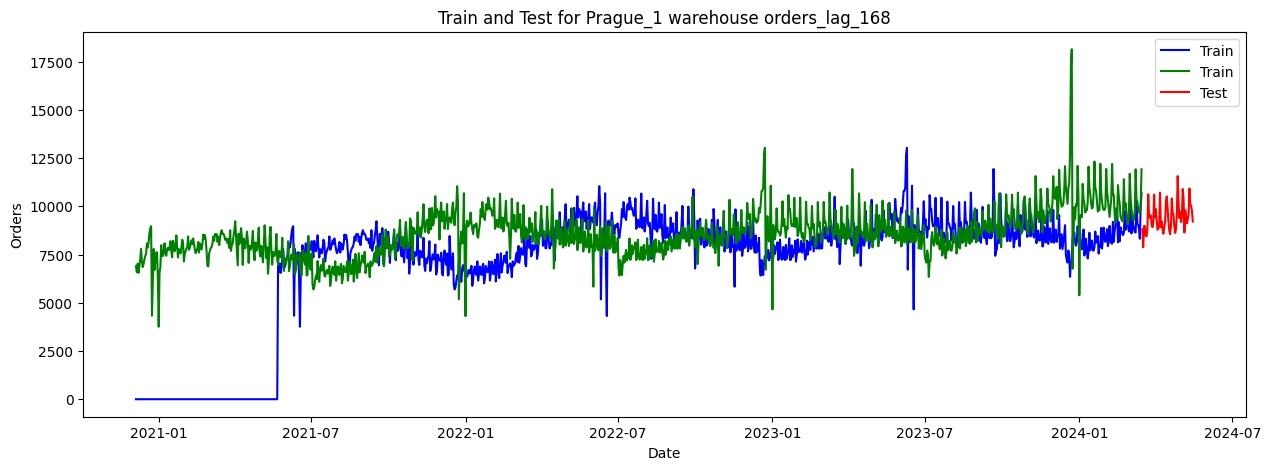

In [922]:
# plot the train and test datasets and visualise them in diferent colors for only column of every warehouse
feature = f'orders_lag_{LAG_DAYS[2]}' # third lag feature for test data

for warehouse in train_df['warehouse'].unique():
    plt.figure(figsize=(15, 5)) 
    datax = train_df[train_df['warehouse'] == warehouse]
    datax_test = test_df[test_df['warehouse'] == warehouse]
    plt.plot(datax.index, datax[feature], label='Train', color='blue')
    plt.plot(datax.index, datax['orders'], label='Train', color='green')
    plt.plot(datax_test.index, datax_test[feature], label='Test', color='red')
    plt.title(f'Train and Test for {warehouse} warehouse {feature}')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()

In [923]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (1193, 30)
Test data: (61, 30)


In [924]:
"""lag_roll features
"""
LAG_ROLL_FEATURES = []
for feature in numerical_features:
    if 'lag' in feature or 'rolling' in feature:
        LAG_ROLL_FEATURES.append(feature)
print(LAG_ROLL_FEATURES)                                             

['orders_lag_63', 'orders_lag_119', 'orders_lag_168', 'orders_lag_364', 'orders_rolling_mean_63', 'orders_rolling_std_63', 'orders_rolling_mean_168', 'orders_rolling_std_168', 'orders_rolling_mean_364', 'orders_rolling_std_364']


In [925]:
x_scaler_features = list(set(train_df.columns) - set(categorical_features) - set(binary_features) - {'warehouse', 'orders'})
print(x_scaler_features)

['days_since_start', 'orders_rolling_std_168', 'day_cos', 'year_cos', 'orders_lag_364', 'orders_lag_168', 'orders_lag_119', 'year_sin', 'month', 'day', 'orders_rolling_std_63', 'month_cos', 'day_of_year', 'orders_rolling_std_364', 'orders_rolling_mean_364', 'month_sin', 'orders_rolling_mean_63', 'orders_lag_63', 'orders_rolling_mean_168', 'day_sin']


In [926]:
print("Start Date:", train_df.index.min())
print("End Date:", train_df.index.max())        

Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00


## Training Loop

In [927]:
train_df.head()

,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,orders_lag_63,orders_lag_119,orders_lag_168,orders_lag_364,orders_rolling_mean_63,orders_rolling_std_63,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,Prague_1,6895.0,0,0,0,0,4,2020,12,5,5,340,1,0,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,0.0,0.0,0.0,0.0,6895.000000,0.000000,6895.000000,0.000000,6895.000000,0.000000
2020-12-06,Prague_1,6584.0,0,0,0,0,4,2020,12,6,6,341,1,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-8.817457e-15,6.0,0.0,0.0,0.0,0.0,6739.500000,219.910209,6739.500000,219.910209,6739.500000,219.910209
2020-12-07,Prague_1,7030.0,0,0,0,0,4,2020,12,7,0,342,0,2,-1.630940e-09,2020.0,-3.526983e-14,12.0,-1.200154e-14,7.0,0.0,0.0,0.0,0.0,6836.333333,228.714524,6836.333333,228.714524,6836.333333,228.714524
2020-12-08,Prague_1,6550.0,0,0,0,0,4,2020,12,8,1,343,0,3,-1.630940e-09,2020.0,-3.526983e-14,12.0,-1.567548e-14,8.0,0.0,0.0,0.0,0.0,6764.750000,235.308840,6764.750000,235.308840,6764.750000,235.308840
2020-12-09,Prague_1,6910.0,0,0,0,0,4,2020,12,9,2,344,0,4,-1.630940e-09,2020.0,-3.526983e-14,12.0,-1.983928e-14,9.0,0.0,0.0,0.0,0.0,6793.800000,213.885951,6793.800000,213.885951,6793.800000,213.885951


In [928]:
def preprocess_data(df, cat_features, x_scaler_features, binary_features, inference=False):
    #if not inference:
        # Create lag and rolling features
        #df, lag_features = create_lag_features(df, 'orders', LAG_DAYS)
        #df, window_features = create_rolling_features(df, 'orders', ROLLING_WINDOW)

        # Handle NaN values in lag and rolling features
        #df[lag_features + window_features] = df[lag_features + window_features].fillna(method='ffill').fillna(method='bfill')
        #df[lag_features + window_features] = df[lag_features + window_features].fillna(0)


    # One-hot encoding for categorical features
    if not inference:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_features = encoder.fit_transform(df[cat_features])
        joblib.dump(encoder, 'onehot_scaler_st.joblib')
    else:
        encoder = joblib.load('onehot_scaler_st.joblib')
        encoded_features = encoder.transform(df[cat_features])

    encoded_feature_names = encoder.get_feature_names_out(cat_features)
    encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)

    # Prepare features for scaling
    if not inference:
        X = df.drop(columns=['orders'])
        y = df['orders']
    else:
        X = df.copy()

    # Initialize and fit/transform scalers
    if not inference:
        x_scaler = StandardScaler()
        y_scaler = StandardScaler()
        X_scaled = x_scaler.fit_transform(X[x_scaler_features])
        y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
        joblib.dump(x_scaler, 'x_scaler_st.joblib')
        joblib.dump(y_scaler, 'y_scaler_st.joblib')
    else:
        x_scaler = joblib.load('x_scaler_st.joblib')
        X_scaled = x_scaler.transform(X[x_scaler_features])
        y_scaled = None  # No target variable during inference

    # Create DataFrame with scaled features
    X_scaled_df = pd.DataFrame(X_scaled, columns=x_scaler_features, index=df.index)

    # Combine all features
    final_df = pd.concat([
        X_scaled_df,  # Scaled numerical features
        encoded_df,   # One-hot encoded categorical features
        df[binary_features]  # Binary features (unchanged)
    ], axis=1)

    if not inference:
        return final_df, y_scaled
    else:
        return final_df


In [929]:
def create_sequences(X_train_scaled, y_train_scaled, time_steps):
    # Create sequences for each warehouse
    
    sequences = []
    targets = []

    if len(X_train_scaled) > time_steps:
        generator = TimeseriesGenerator(X_train_scaled.values, 
                                        y_train_scaled, 
                                        length=time_steps, 
                                        batch_size=1)
        
        for i in range(len(generator)):
            x, y = generator[i]
            sequences.append(x)
            targets.append(y)

    X = np.array(sequences)
    y = np.array(targets)

    X = np.squeeze(X, axis=1)
    y = np.squeeze(y, axis=1)
    
    print(f"final shape: {X.shape, y.shape}")
    
    return X, y

In [930]:
def create_model(input_shape, lr=1e-3):

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=16, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(units=1))

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=lr))

    return model

In [931]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss of {warehouse}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [932]:
print(train_df.isna().sum())

warehouse                  0
orders                     0
holiday                    0
shops_closed               0
winter_school_holidays     0
school_holidays            0
quarter                    0
year                       0
month                      0
day                        0
day_of_week                0
day_of_year                0
is_weekend                 0
days_since_start           0
year_sin                   0
year_cos                   0
month_sin                  0
month_cos                  0
day_sin                    0
day_cos                    0
orders_lag_63              0
orders_lag_119             0
orders_lag_168             0
orders_lag_364             0
orders_rolling_mean_63     0
orders_rolling_std_63      0
orders_rolling_mean_168    0
orders_rolling_std_168     0
orders_rolling_mean_364    0
orders_rolling_std_364     0
dtype: int64


In [933]:
X_train_scaled, y_train_scaled = preprocess_data(train_df, categorical_features, x_scaler_features, binary_features)
len(X_train_scaled.columns)

41

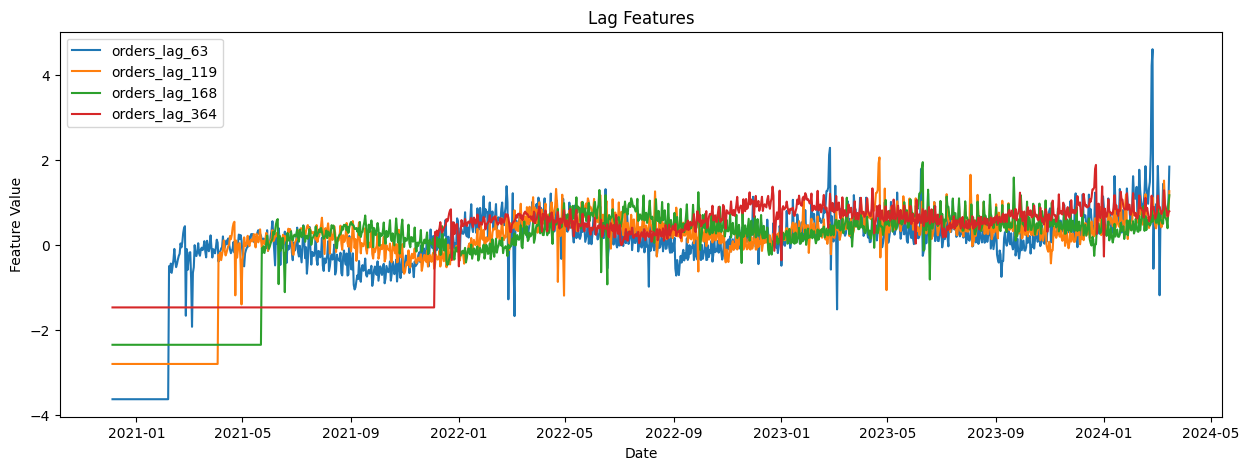

In [934]:

#Plot x_train lag feeatures
plt.figure(figsize=(15, 5))
for feature in lag_features:
    plt.plot(X_train_scaled.index, X_train_scaled[feature], label=feature)
plt.title("Lag Features")
plt.xlabel("Date")
plt.ylabel("Feature Value")
plt.legend()
plt.show()


Training model for warehouse: Prague_1
final shape: ((1130, 63, 41), (1130, 1))
Epoch 1/100
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.6129
Epoch 1: val_loss improved from inf to 0.54260, saving model to model_Prague_1_st.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 1.6017 - val_loss: 0.5426
Epoch 2/100
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.1511
Epoch 2: val_loss improved from 0.54260 to 0.50609, saving model to model_Prague_1_st.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 1.1445 - val_loss: 0.5061
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.9751
Epoch 3: val_loss improved from 0.50609 to 0.42188, saving model to model_Prague_1_st.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.9731 - val_loss: 0.4219
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.8370
Epoch 4: val_loss improved from 0.42188 to 0.38061, saving model to model_Prague_1_st.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.8370 - val_loss

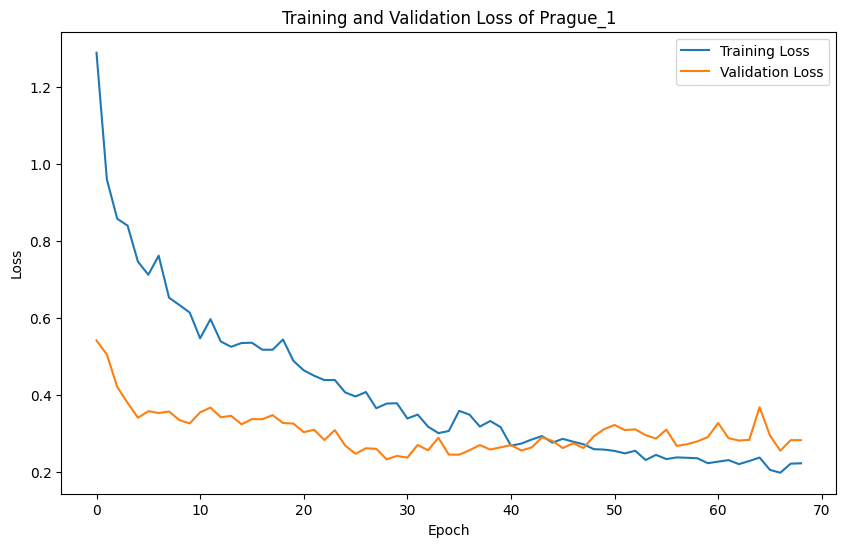

In [935]:
# Train models for each warehouse
warehouses = train_df['warehouse'].unique()
val_data = {}

for warehouse in warehouses:
    print(f"Training model for warehouse: {warehouse}")
    
    X_train_wh = X_train_scaled[train_df['warehouse'] == warehouse]
    y_train_wh = y_train_scaled[train_df['warehouse'] == warehouse]
    

    # Create sequences
    X_seq, y_seq = create_sequences(X_train_wh, y_train_wh, time_steps=TIME_STEPS)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=True, random_state=42)
    
    # Create and train model
    model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True),
        ModelCheckpoint(f'model_{warehouse}_st.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
    ]
    
    # Save the val data in the "val_data" dictionary for each warehouse:
    val_data[warehouse] = (X_val, y_val)
    
    
    history = model.fit(
        X_train, y_train, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        validation_data=(X_val, y_val), 
        callbacks=callbacks,
        verbose=1
    )
    
    plot_loss(history)

In [936]:
X_train_scaled.head()

,days_since_start,orders_rolling_std_168,day_cos,year_cos,orders_lag_364,orders_lag_168,orders_lag_119,year_sin,month,day,orders_rolling_std_63,month_cos,day_of_year,orders_rolling_std_364,orders_rolling_mean_364,month_sin,orders_rolling_mean_63,orders_lag_63,orders_rolling_mean_168,day_sin,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4,year_2020,year_2021,year_2022,year_2023,year_2024,is_weekend,holiday,shops_closed,winter_school_holidays,school_holidays
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,-1.732070,-4.301166,-1.211889,-2.145151,-1.470663,-2.350405,-2.801653,-0.30871,1.577677,-1.211889,-2.538268,1.577677,1.483102,-5.575966,-2.517771,-0.595108,-1.750054,-3.632029,-2.082228,0.513699,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0
2020-12-06,-1.729174,-3.207852,-1.097922,-2.145151,-1.470663,-2.350405,-2.801653,-0.30871,1.577677,-1.097922,-1.802468,1.577677,1.492208,-4.252998,-2.814418,-0.595108,-1.924150,-3.632029,-2.306609,0.497673,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0
2020-12-07,-1.726278,-3.164080,-0.983955,-2.145151,-1.470663,-2.350405,-2.801653,-0.30871,1.577677,-0.983955,-1.773010,1.577677,1.501315,-4.200031,-2.629689,-0.595108,-1.815736,-3.632029,-2.166882,0.478733,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0
2020-12-08,-1.723382,-3.131295,-0.869988,-2.145151,-1.470663,-2.350405,-2.801653,-0.30871,1.577677,-0.869988,-1.750946,1.577677,1.510421,-4.160360,-2.766249,-0.595108,-1.895880,-3.632029,-2.270174,0.456880,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0
2020-12-09,-1.720486,-3.237802,-0.756021,-2.145151,-1.470663,-2.350405,-2.801653,-0.30871,1.577677,-0.756021,-1.822625,1.577677,1.519528,-4.289239,-2.710830,-0.595108,-1.863356,-3.632029,-2.228256,0.432113,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0


In [937]:
len(X_train_scaled.columns)

41

In [938]:
X_train_scaled.columns

Index(['days_since_start', 'orders_rolling_std_168', 'day_cos', 'year_cos',
       'orders_lag_364', 'orders_lag_168', 'orders_lag_119', 'year_sin',
       'month', 'day', 'orders_rolling_std_63', 'month_cos', 'day_of_year',
       'orders_rolling_std_364', 'orders_rolling_mean_364', 'month_sin',
       'orders_rolling_mean_63', 'orders_lag_63', 'orders_rolling_mean_168',
       'day_sin', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
       'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'year_2020',
       'year_2021', 'year_2022', 'year_2023', 'year_2024', 'is_weekend',
       'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays'],
      dtype='object')

In [939]:
# Save all scaler features into singe json scaler config file:
scaler_config = {
    'bin_features': binary_features,
    'cat_features': categorical_features,
    'scaler_features': x_scaler_features,
    'training_features': X_train_scaled.columns.tolist()
}

# Save the scaler config
joblib.dump(scaler_config, 'scaler_config_st.joblib')

['scaler_config_st.joblib']

## MAPE Eval

### Visualize predictions on the training data

Predicting for warehouse: Prague_1
final shape: ((1130, 63, 41), (1130, 1))
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


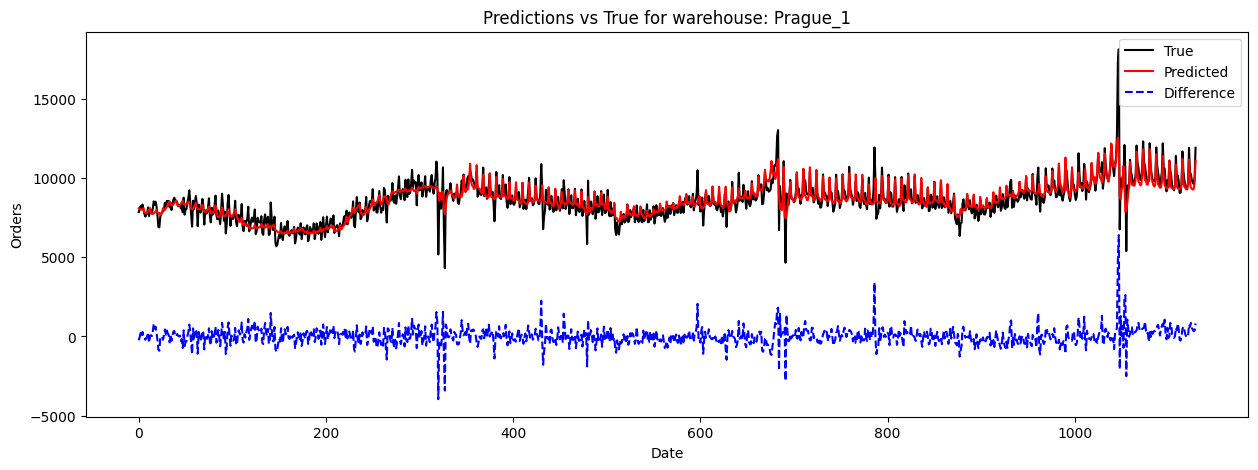


Mean Absolute Percentage Error on training data for Prague_1: 4.4545%

MAPE training scores: 
Prague_1: 4.4545%

Mean training MAPE: 4.4545%


In [940]:
# Predict and visualise MAPE for each warehouse with its model and scaler:
mape_scores = []
y_scaler = joblib.load('y_scaler_st.joblib')
X_train_scaled, y_train_scaled = preprocess_data(train_df, categorical_features, x_scaler_features, binary_features)
    
for warehouse in warehouses:
    print(f"Predicting for warehouse: {warehouse}")
    
    X_train = X_train_scaled[train_df['warehouse'] == warehouse]
    y_train = y_train_scaled[train_df['warehouse'] == warehouse]
    
    # Create sequences
    X_seq, y_seq = create_sequences(X_train, y_train, time_steps=TIME_STEPS)
    
    # Load the model
    model = tf.keras.models.load_model(f'model_{warehouse}_st.keras')
    
    # Predict
    predictions = model.predict(X_seq)
    predictions = y_scaler.inverse_transform(predictions)
    y_seq_unscaled = y_scaler.inverse_transform(y_seq)
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_seq_unscaled, predictions) * 100
    mape_scores.append(mape)
    
    # Visualise the predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_seq_unscaled, label='True', color='black')
    plt.plot(predictions, label='Predicted', color='red')
    plt.plot(y_seq_unscaled - predictions, label='Difference', color='blue', linestyle='--')
    plt.title(f'Predictions vs True for warehouse: {warehouse}')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()
    
    print(f'\nMean Absolute Percentage Error on training data for {warehouse}: {mape:.4f}%')

print("\nMAPE training scores: ")
for i, score in enumerate(mape_scores):
    print(f"{warehouses[i]}: {score:.4f}%")

print(f"\nMean training MAPE: {np.mean(mape_scores):.4f}%")   

### Visualize predictions on the validation data

Predicting for warehouse: Prague_1
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step


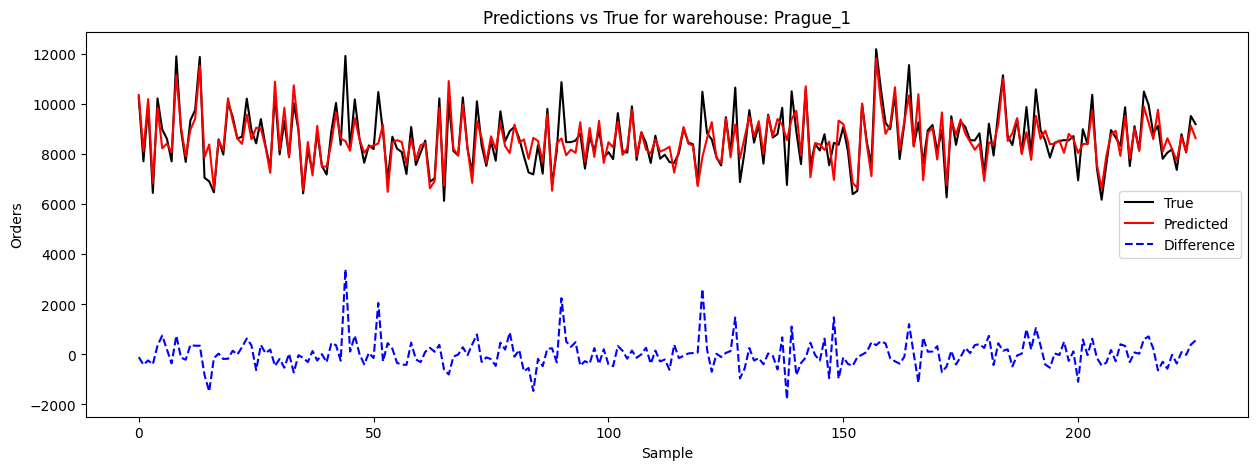


Mean Absolute Percentage Error on validation data for Prague_1: 4.6216%

MAPE validation scores: 
Prague_1: 4.6216%

Mean validation MAPE: 4.6216%


In [941]:
mape_scores = []
y_scaler = joblib.load('y_scaler_st.joblib')

for warehouse in warehouses:
    print(f"Predicting for warehouse: {warehouse}")
    
    # Load the validation data for the current warehouse
    X_val, y_val = val_data[warehouse]
    
    # Load the model
    model = tf.keras.models.load_model(f'model_{warehouse}_st.keras')
    
    # Predict
    predictions = model.predict(X_val)
    predictions = y_scaler.inverse_transform(predictions)
    y_val_unscaled = y_scaler.inverse_transform(y_val)
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_val_unscaled, predictions) * 100
    mape_scores.append(mape)
    
    # Visualise the predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_val_unscaled, label='True', color='black')
    plt.plot(predictions, label='Predicted', color='red')
    plt.plot(y_val_unscaled - predictions, label='Difference', color='blue', linestyle='--')
    plt.title(f'Predictions vs True for warehouse: {warehouse}')
    plt.xlabel('Sample')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()
    
    print(f'\nMean Absolute Percentage Error on validation data for {warehouse}: {mape:.4f}%')

print("\nMAPE validation scores: ")
for i, score in enumerate(mape_scores):
    print(f"{warehouses[i]}: {score:.4f}%")

print(f"\nMean validation MAPE: {np.mean(mape_scores):.4f}%")

## Inference and visualisation on test data:

In [942]:

def create_sequences(data, max_time_steps):

    sequences = []
    for i in range(len(data)):
        seq = data.iloc[max(0, i-max_time_steps+1):i+1].values
        if len(seq) < max_time_steps:
            padding = np.tile(seq[0], (max_time_steps - len(seq), 1))
            seq = np.vstack((padding, seq))
        sequences.append(seq)
    return np.array(sequences)


In [943]:
def predict_multiple(data, time_steps, warehouse_models, y_scaler, training_features):
    predictions = []
    submission_data = []

    for warehouse in data['warehouse'].unique():
        if warehouse not in warehouse_models:
            print(f"No model found for warehouse: {warehouse}")
            warehouse_predictions = [np.nan] * len(data[data['warehouse'] == warehouse])
            predictions.extend(warehouse_predictions)
            continue

        model = warehouse_models[warehouse]
        wh_data = data[data['warehouse'] == warehouse].copy()
        wh_data = wh_data.reindex(columns=training_features)

        sequences = create_sequences(wh_data, time_steps)
        
        # how many sequences and what shape ?
        print(f"sequences shape: {sequences.shape}")
        
        
        # Predict on all sequences
        preds = model.predict(sequences)
        preds_rescaled = y_scaler.inverse_transform(preds)
        
        # Align predictions with original data
        wh_predictions = np.full(len(wh_data), np.nan)
        
        # Adjust predictions based on time_steps
        if time_steps > 1:
            # We only keep the last prediction for each sequence
            preds_rescaled = preds_rescaled[:, -1]
        
        # Calculate the number of predictions
        num_predictions = len(preds_rescaled)
        
        # Assign predictions, accounting for the offset due to sequence creation
        wh_predictions[-num_predictions:] = preds_rescaled.flatten()
        predictions.extend(wh_predictions)

        # Prepare submission data
        wh_submission_data = data.loc[data['warehouse'] == warehouse].copy()
        wh_submission_data['predicted_orders'] = wh_predictions
        submission_data.append(wh_submission_data)

    submission_df = pd.concat(submission_data)
    return np.array(predictions), submission_df

In [944]:
def load_models_and_scalers(warehouses):
    warehouse_models = {}
    for wh in warehouses:
        try:
            model = tf.keras.models.load_model(f'model_{wh}_st.keras')
            warehouse_models[wh] = model
        except Exception as e:
            print(f"Error loading model for warehouse {wh}: {str(e)}")
    return warehouse_models

In [945]:
dataframe = pd.read_csv("data/test_proc_st.csv")
dataframe['date'] = pd.to_datetime(dataframe['date'])
dataframe = dataframe.sort_values(by=['date', 'warehouse'])
dataframe.head()
print(f"Rows: {len(dataframe)}")

Rows: 61


In [946]:
# load scaler config:
scaler_config = joblib.load('scaler_config_st.joblib') # load the scaler config
ohsc = joblib.load("onehot_scaler_st.joblib")   # OneHotEncoder for categorical features

x_scaler_features = scaler_config['scaler_features']   # standard scaler features in the right order that the training dataset was scaled on
categorical_features = scaler_config['cat_features']    # categorical features
binary_features = scaler_config['bin_features']    # binary features are unpluged before scaling and then plugged back in after scaling
training_features = scaler_config['training_features']
    
print(f"cat_features: {categorical_features}")
print(f"binary_features: {binary_features}")
print(f"scaler_columns: {len(x_scaler_features)}")

cat_features: ['day_of_week', 'quarter', 'year']
binary_features: ['is_weekend', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']
scaler_columns: 20


In [947]:
len(training_features)

41

In [948]:
id = dataframe['id']
date = dataframe['date']
warehouse = dataframe["warehouse"]

In [949]:
processed_data = preprocess_data(dataframe, categorical_features, x_scaler_features, binary_features, inference=True)
processed_data = pd.concat([warehouse, processed_data], axis=1)
processed_data = processed_data.set_index(dataframe.date)
len(processed_data.columns)

42

In [950]:
# Load models and scalers
warehouses = processed_data['warehouse'].unique()
warehouse_models = load_models_and_scalers(warehouses)
y_scaler = joblib.load('y_scaler_st.joblib')

In [951]:
predictions, submission_df = predict_multiple(processed_data, TIME_STEPS, warehouse_models, y_scaler, training_features)

sequences shape: (61, 63, 41)
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 741ms/step


In [952]:
# Align 'id' and 'date' with the original dataframe
dataframe = dataframe.set_index('date')
submission_df['id'] = submission_df.index.map(lambda x: dataframe.loc[x, 'id'] if x in dataframe.index else np.nan)
submission_df['date'] = submission_df.index

# Save submission CSV
submission_df.to_csv('submission_multi_warehouse.csv', index=False)

In [953]:
len(submission_df.predicted_orders)

61

In [954]:
submission_df.tail()

,warehouse,days_since_start,orders_rolling_std_168,day_cos,year_cos,orders_lag_364,orders_lag_168,orders_lag_119,year_sin,month,day,orders_rolling_std_63,month_cos,day_of_year,orders_rolling_std_364,orders_rolling_mean_364,month_sin,orders_rolling_mean_63,orders_lag_63,orders_rolling_mean_168,day_sin,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4,year_2020,year_2021,year_2022,year_2023,year_2024,is_weekend,holiday,shops_closed,winter_school_holidays,school_holidays,predicted_orders,id,date
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-05-11,Prague_1,1.896546,2.715946,-0.528088,1.975888,1.180259,1.254327,1.295139,1.381981,-0.371314,-0.528088,0.317180,-0.371314,-0.411082,2.369975,2.136972,0.463266,1.992551,1.067145,2.926548,-0.091071,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,9426.283203,Prague_1_2024-05-11,2024-05-11
2024-05-12,Prague_1,1.899442,2.747077,-0.414121,1.975888,0.812003,0.989632,1.168234,1.381981,-0.371314,-0.414121,0.654142,-0.371314,-0.401975,2.381332,2.139909,0.463266,1.989826,1.024441,2.929778,0.340329,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,9381.553711,Prague_1_2024-05-12,2024-05-12
2024-05-13,Prague_1,1.902338,2.777467,-0.300154,1.975888,0.793462,0.951347,0.994300,1.381981,-0.371314,-0.300154,1.060638,-0.371314,-0.392868,2.392187,2.143314,0.463266,2.093221,0.849994,2.934602,0.853345,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,9318.932617,Prague_1_2024-05-13,2024-05-13
2024-05-14,Prague_1,1.905234,2.804390,-0.186187,1.975888,0.922737,0.871807,0.886804,1.381981,-0.371314,-0.186187,1.533591,-0.371314,-0.383762,2.405310,2.143592,0.463266,2.323763,0.779125,2.942735,0.264571,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,9382.427734,Prague_1_2024-05-14,2024-05-14
2024-05-15,Prague_1,1.908130,2.815135,-0.072220,1.975888,0.695861,0.687643,0.910692,1.381981,-0.371314,-0.072220,1.864704,-0.371314,-0.374655,2.412070,2.149419,0.463266,2.830751,0.741873,2.958546,-0.411645,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,9795.817383,Prague_1_2024-05-15,2024-05-15


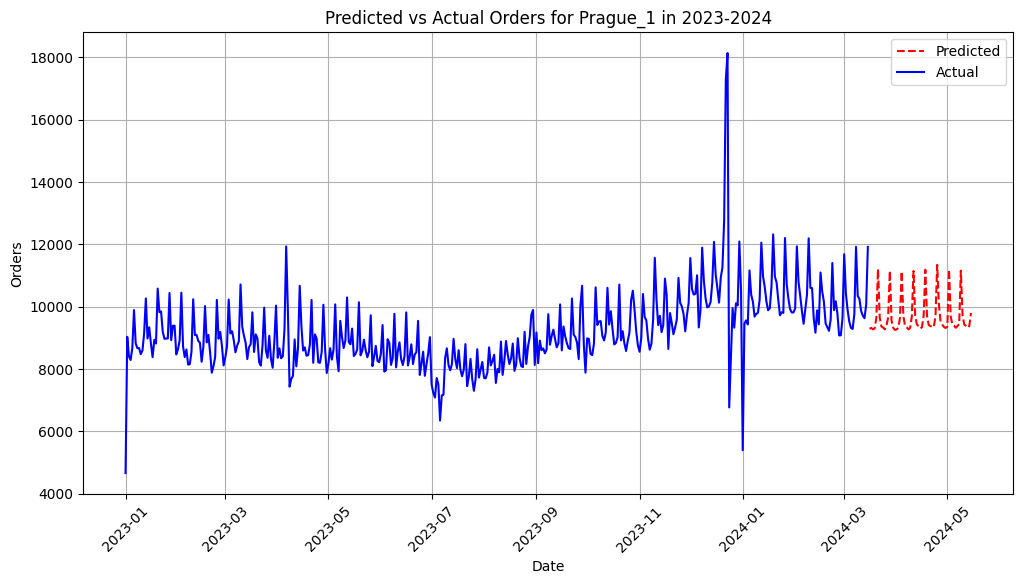

Predictions complete. Submission file and plots created.


In [955]:
# Plot predictions for each warehouse
train_df_raw = pd.read_csv("data/train.csv")
train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])

last_year_data = train_df_raw[train_df_raw['date'].dt.year > 2022]

for wh in warehouses:

    wh_df_pred = submission_df[submission_df['warehouse'] == wh]
    wh_df_last_year = last_year_data[last_year_data['warehouse'] == wh]
    
    # Plot data (training data from 2023)

    plt.figure(figsize=(12, 6))
    
    plt.plot(wh_df_pred.index, wh_df_pred['predicted_orders'], label='Predicted',  linestyle='--', color='red')

    plt.plot(wh_df_last_year.date, wh_df_last_year['orders'], label='Actual', color='blue')

    plt.title(f'Predicted vs Actual Orders for {wh} in 2023-2024')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig(f'prediction_plot_{wh}.png')
    plt.show()
    plt.close()

print("Predictions complete. Submission file and plots created.")